# Parallelization

**Parallelization with LLMs (Large Language Models)** means running multiple parts of a task at the same time to work faster or get better results. There are two main ways to do this:

1. **Sectioning** – Split a task into smaller, separate parts and run them all at once.
2. **Voting** – Run the same task multiple times and combine the different results to choose the best one.

**When to use it:**
Use parallelization when:

* You want to save time by doing parts of a task in parallel.
* You want more accurate or creative results by comparing multiple answers.
* The task is complex and needs different parts handled separately for better quality.

## Prerequisite

- [Ollama](https://ollama.com/) installed to generate the graph
- Taviley search tool to retrieve context for our usecase.

Download the granite model

```sh
ollama pull granite3.2:2b  
```


In [ ]:
%%capture --no-stderr
## lets start with installing all the required libraries
%pip install --upgrade --quiet langgraph  langchain langchain-community langchain-ollama langchain-experimental python-dotenv langchain_core tavily-python wikipedia

In [2]:
## Load the environment variable from .env file

import os
from dotenv import load_dotenv
load_dotenv()

True

### LLM Model using OLLAMA

In [27]:
### LLM
from langchain_ollama import ChatOllama
from IPython.display import display

local_llm = "granite3.2:2b"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [8]:
## Testing the LLM model

from langchain_core.messages import HumanMessage

# Create a message
msg = HumanMessage(content="Hello how are you?", name="Himadri")

# Message list
messages = [msg]

# Invoke the model with a list of messages 
response=llm_json_mode.invoke(messages)
print(response.content)

{
"response": "I'm an artificial intelligence and don't have feelings, but I'm functioning well, thank you! As for you, I'm here to provide assistance and make your interaction as smooth as possible."
}


## Usecase:

In this lesson, we'll explore a use case where we summarize a document using a parallel workflow.
Since LLMs have a limited context length, we'll split the document into four parts and summarize each part separately in parallel. Then, we'll combine those four summaries into one final summary that represents the entire document.

In [18]:
from typing import List
from math import ceil

# Step 1: Split the list into 4 roughly equal parts
def split_into_chunks(doc_list, n_chunks=4):
    chunk_size = ceil(len(doc_list) / n_chunks)
    return [doc_list[i * chunk_size:(i + 1) * chunk_size] for i in range(n_chunks)]

## Lets build the Parallelization workflow using LangGraph

In [33]:
from langchain_core.messages import HumanMessage, SystemMessage

prompt = """Provide a one-paragraph summary of the following wikipedia paragraph:

{article}

Summarization:"""

doc_text = prompt.format(article=combined_contents[0])
summarized_doc = llm.invoke([HumanMessage(content=doc_text)])

summarized_doc.content

"IBM introduced the Personal Computer AT (AT) in 1984 as its fourth model in the IBM Personal Computer line, following the PC/XT and Portable PC. This move was unusual for IBM, which usually waited for competitors to release new products before producing their own models. The AT was priced similarly to slower IBM models at $4,000–6,000, surprising rival executives who found it difficult to match the price.\n\nKey features of the IBM Personal Computer AT include:\n\n1. **Processor**: It was compatible with the Intel 80286 processor, offering faster execution of floating-point operations compared to previous models' 8088 processors.\n\n2. **AT Bus (ISA)**: The AT introduced this 16-bit bus, which provided fifteen IRQs and seven DMA channels, expanding from the PC's eight IRQs and four DMA channels. This enhancement allowed for better expansion card compatibility and functionality.\n\n3. **Memory Support**: With a 24-bit address bus supporting the 80286 processor, RAM capacity expanded to

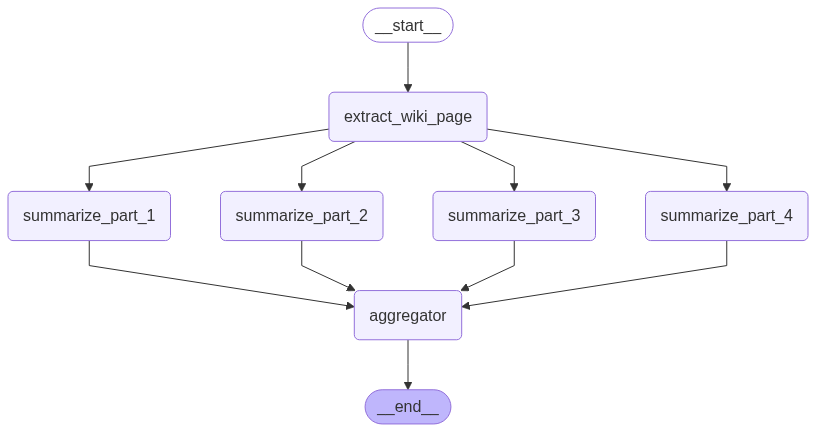

In [39]:
from langchain.document_loaders import WikipediaLoader
from typing_extensions import TypedDict, List, Any
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Define graph state

class State(TypedDict):
    wiki_title: str
    combined_contents: List[str]
    summary1: str
    summary2: str
    summary3: str
    summary4: str
    summaryFinal: str
    

# Nodes

def extract_wiki_page(state: State):
    raw_documents = WikipediaLoader(query=state["wiki_title"]).load()
    chunks = split_into_chunks(raw_documents, 4)
    combined_contents = ["\n\n".join(doc.page_content for doc in chunk) for chunk in chunks]
    return { "combined_contents":  combined_contents}

def summarize_part_1(state: State):
    """Summarize wiki paragraph part 1"""

    print("___SUMMARIZE_PART_1___")
    doc_text = prompt.format(article=state["combined_contents"][0])
    summarized_doc = llm.invoke([HumanMessage(content=doc_text)])

    return {"summary1": summarized_doc.content}

def summarize_part_2(state: State):
    """Summarize wiki paragraph part 2"""

    print("___SUMMARIZE_PART_2___")
    doc_text = prompt.format(article=state["combined_contents"][1])
    summarized_doc = llm.invoke([HumanMessage(content=doc_text)])

    return {"summary2": summarized_doc.content}

def summarize_part_3(state: State):
    """Summarize wiki paragraph part 3"""

    print("___SUMMARIZE_PART_3___")
    doc_text = prompt.format(article=state["combined_contents"][2])
    summarized_doc = llm.invoke([HumanMessage(content=doc_text)])

    return {"summary3": summarized_doc.content}

def summarize_part_4(state: State):
    """Summarize wiki paragraph part 4"""

    print("___SUMMARIZE_PART_4___")
    doc_text = prompt.format(article=state["combined_contents"][3])
    summarized_doc = llm.invoke([HumanMessage(content=doc_text)])

    return {"summary4": summarized_doc.content}


def aggregator(state: State):
    """Summarize wiki paragraph final all four part"""

    print("___SUMMARIZE_PART_FINAL___")
    
    doc_text = state["summary1"] + "\n\n" + state["summary2"] + "\n\n" + state["summary3"] + "\n\n" + state["summary4"]
    
    summarized_doc = llm.invoke([HumanMessage(content=doc_text)])

    return {"summaryFinal": summarized_doc.content}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("extract_wiki_page", extract_wiki_page)

parallel_builder.add_node("summarize_part_1", summarize_part_1)
parallel_builder.add_node("summarize_part_2", summarize_part_2)
parallel_builder.add_node("summarize_part_3", summarize_part_3)
parallel_builder.add_node("summarize_part_4", summarize_part_4)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes

parallel_builder.add_edge(START, "extract_wiki_page")

parallel_builder.add_edge("extract_wiki_page", "summarize_part_1")
parallel_builder.add_edge("extract_wiki_page", "summarize_part_2")
parallel_builder.add_edge("extract_wiki_page", "summarize_part_3")
parallel_builder.add_edge("extract_wiki_page", "summarize_part_4")

parallel_builder.add_edge("summarize_part_1", "aggregator")
parallel_builder.add_edge("summarize_part_2", "aggregator")
parallel_builder.add_edge("summarize_part_3", "aggregator")
parallel_builder.add_edge("summarize_part_4", "aggregator")

parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))



In [40]:

# Invoke
state = parallel_workflow.invoke({"wiki_title": "IBM"})
print(state["summaryFinal"])

/Users/htalukder/mlops/learning/ai-agents/.venv/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/htalukder/mlops/learning/ai-agents/.venv/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


___SUMMARIZE_PART_1___
___SUMMARIZE_PART_2___
___SUMMARIZE_PART_3___
___SUMMARIZE_PART_4___
___SUMMARIZE_PART_FINAL___
**Comparison of IBM's Pioneering Portable Computers:**

|   | IBM 5100 (1975) | IBM 4381 (1981) | IBM 9021 (1986) |
|---|---|---|---|
| **Processor** | 16-bit PALM module, up to 64 KB memory | 32-bit Motorola 68000 series | 32-bit Intel 80386SX |
| **Memory** | Up to 64 KB (BASIC or APL) | Up to 1 MB (expandable) | Up to 16 MB (expandable) |
| **Display** | Integrated five-inch CRT, 16 lines of 64 characters per screen | 8.5" TFT color display | 14" TFT color display |
| **Weight** | ~55 lbs (25 kg) | ~7 lbs (3.2 kg) | ~9 lbs (4.1 kg) |
| **Price** | $8,975 - $19,975 (equivalent to $52,000 - $117,000 today) | $6,995 (approximately $13,000 in 1981 dollars) | $4,995 (approximately $10,000 in 1986 dollars) |
| **Key Features** | First portable computer with integrated CRT and substantial memory; offered BASIC and APL programming languages. | Introduced the first IBM lapto